In [445]:
%load_ext autoreload
%autoreload 2

from clust_newlambda import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## here we're running with the likelihood only 

In [340]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [341]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [446]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [447]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [448]:
# Load references (signatures only, no healthy)
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/2429096507.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt'

In [449]:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_var_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.genetic_scale = genetic_scale
/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G_centered = G - G.mean(axis=0, keepdims=True)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:82: UserWarning: To copy construct from a tensor, it is recommended to 


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered

In [450]:
print(model.K_total)
print(model.K)
print(model.lrtpen)

21
20
0


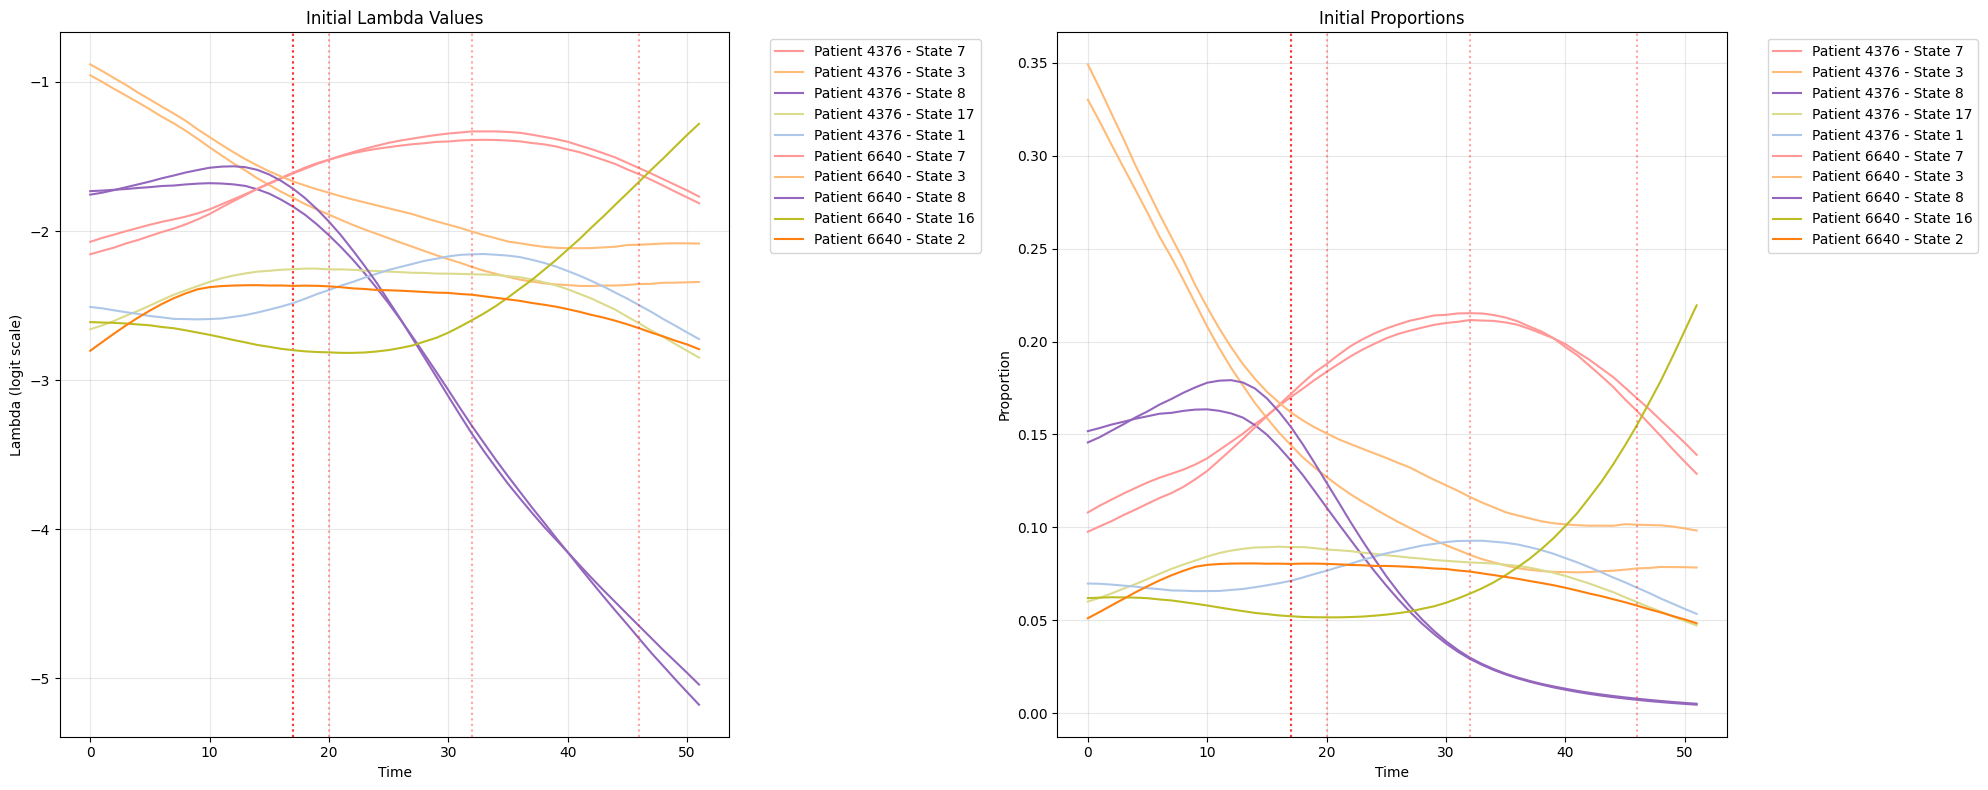


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 7: 0.172
State 3: 0.139
State 8: 0.080
State 17: 0.076
State 1: 0.076

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 7: 0.169
State 3: 0.161
State 8: 0.085
State 16: 0.082
State 2: 0.071


In [452]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Initial Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Initial Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [453]:
print(f"LRT penalty (R): {model.lrtpen}")
print(f"Lambda amplitude: {model.lambda_amplitude}")

LRT penalty (R): 0
Lambda amplitude: 5.0


In [455]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()



In [458]:
import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_100k, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)
        

/Users/sarahurbut/aladynoulli2/pyScripts/clust_newlambda.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.6950

Monitoring signature responses:

Disease 161 (signature 7, LR=32.11):
  Theta for diagnosed: 0.142 ± 0.032
  Theta for others: 0.137
  Proportion difference: 0.004

Disease 76 (signature 7, LR=31.04):
  Theta for diagnosed: 0.141 ± 0.033
  Theta for others: 0.138
  Proportion difference: 0.004

Disease 260 (signature 8, LR=30.56):
  Theta for diagnosed: 0.086 ± 0.069
  Theta for others: 0.084
  Proportion difference: 0.002

Disease 347 (signature 3, LR=29.50):
  Theta for diagnosed: 0.139 ± 0.064
  Theta for others: 0.139
  Proportion difference: -0.000

Disease 50 (signature 15, LR=28.85):
  Theta for diagnosed: 0.017 ± 0.007
  Theta for others: 0.015
  Proportion difference: 0.002

Epoch 1
Loss: 64.3836

Monitoring signature responses:

Disease 161 (signature 7, LR=33.48):
  Theta for diagnosed: 0.133 ± 0.032
  Theta for others: 0.128
  Proportion difference: 0.006

Disease 76 (signature 7, LR=32.57):
  Theta for diagnosed: 0.133 ± 0.033
  Theta for others: 0.

In [429]:
model.phi

Parameter containing:
tensor([[[-15.4416, -15.4349, -15.3587,  ..., -18.0364, -13.3112, -17.3572],
         [-15.9653, -15.9606, -14.5375,  ..., -16.6305, -11.4238, -17.2418],
         [-17.2622, -17.1940, -17.0483,  ..., -17.2061, -11.9878, -16.5762],
         ...,
         [-15.5709, -15.5693, -15.5042,  ..., -16.5578, -11.3443, -16.1072],
         [-17.6423, -17.5345, -17.3321,  ..., -15.0084, -10.8331, -15.1468],
         [-16.4798, -16.4396, -16.3318,  ..., -18.1918, -13.7857, -17.5212]],

        [[-15.7768, -19.3148, -15.8763,  ..., -14.2936, -13.7663, -14.2518],
         [-17.1038, -19.7816, -14.1864,  ..., -12.9646, -11.3986, -14.1383],
         [-18.0159, -20.1839, -18.0711,  ..., -13.2636, -12.4249, -13.1858],
         ...,
         [-16.0202, -19.5536, -16.1362,  ..., -12.6498, -11.5541, -12.9274],
         [-18.3555, -20.1612, -18.3197,  ..., -11.2381, -11.3568, -11.8723],
         [-17.6063, -19.8695, -17.6736,  ..., -14.1427, -13.8012, -14.1327]],

        [[-17.1993, -1

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_57289/2612062181.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


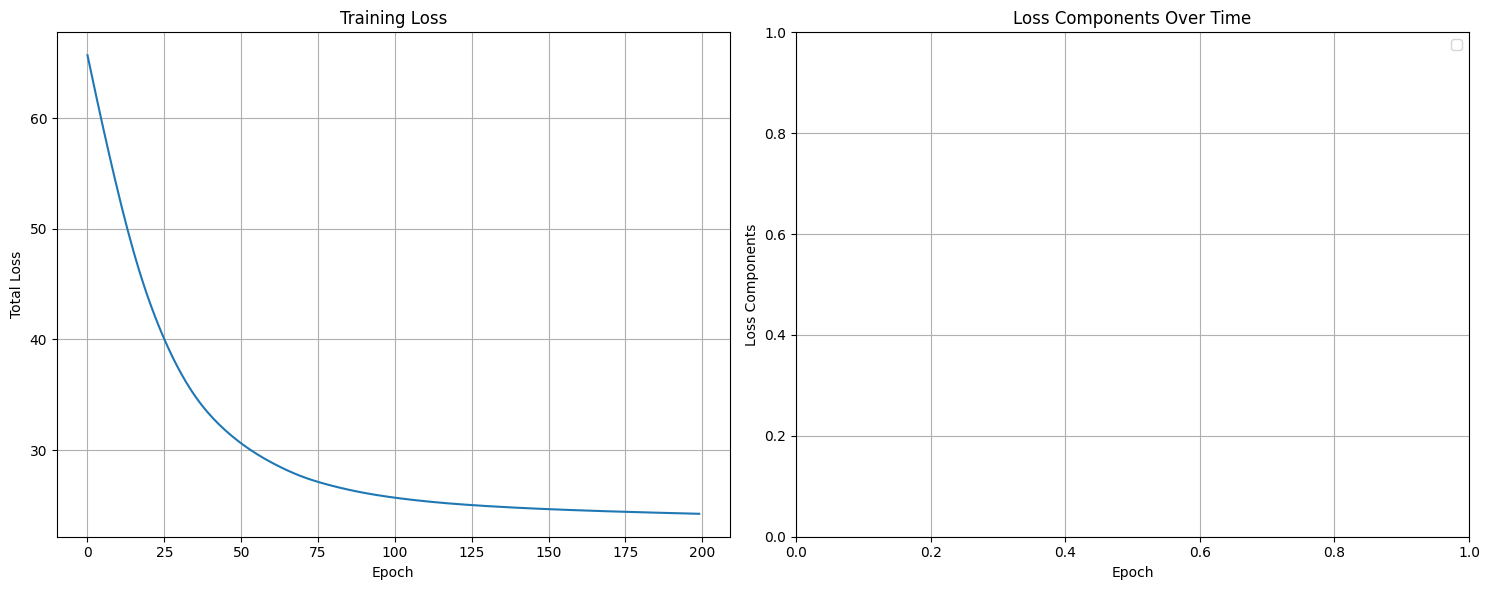

In [460]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot total loss
    ax1.plot(history)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)

    # Plot component losses
    # Extract from printed output
    epochs = range(len(history))
    #data_losses = [65.6950, 65.6198, 65.5456, 65.4711, 65.3961, 65.3208, 65.2452, 65.1694, 65.0936, 65.0177, 64.9418, 64.8659, 64.7899, 64.7138, 64.6375, 64.5610, 64.4845, 64.4078, 64.3310, 64.2542]
    #gp_losses = [5.6859, 459.7293, 32.8175, 100.4279, 259.7525, 182.3966, 42.2339, 6.2529, 75.5871, 130.6093, 105.0365, 40.0023, 4.2676, 21.8158, 58.3701, 68.2091, 43.7377, 13.1755, 4.6903, 19.4461]
    #lrt_losses = [16456.7656, 16413.8711, 16375.5742, 16337.2236, 16297.7764, 16257.2930, 16216.2754, 16175.0986, 16134.0918, 16093.5273, 16053.4570, 16013.7744, 15974.3174, 15934.9131, 15895.3779, 15855.5889, 15815.5312, 15775.2656, 15734.9033, 15694.5830]

    #ax2.plot(epochs, data_losses, label='Data Loss', color='blue')
    #ax2.plot(epochs, gp_losses, label='GP Loss', color='green')
    #ax2.plot(epochs, lrt_losses, label='LRT Loss', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Components')
    ax2.set_title('Loss Components Over Time')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history_new)

In [461]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-2:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-2:
Mean absolute change: 3.194e+00
Max absolute change: 1.831e+01
Std of changes: 2.798e+00


In [462]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


In [463]:
def plot_theta_differences():
    diseases = [161, 76, 260, 347, 50]
    signatures = [7, 7, 8, 3, 15]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (d, sig) in enumerate(zip(diseases, signatures)):
        ax = axes[i]
        
        # Get diagnosis times
        diagnosis_mask = model.Y[:, d, :].bool()
        diagnosed = torch.where(diagnosis_mask)[0]
        
        # Get thetas
        pi, theta, phi_prob = model.forward()
        
        # Plot distributions
        diagnosed_theta = theta[diagnosis_mask, sig].detach().numpy()
        others_theta = theta[~diagnosis_mask, sig].detach().numpy()
        
        ax.hist(diagnosed_theta, alpha=0.5, label='At diagnosis', density=True)
        ax.hist(others_theta, alpha=0.5, label='Others', density=True)
        
        ax.set_title(f'Disease {d} (sig {sig})')
        ax.set_xlabel('Theta')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

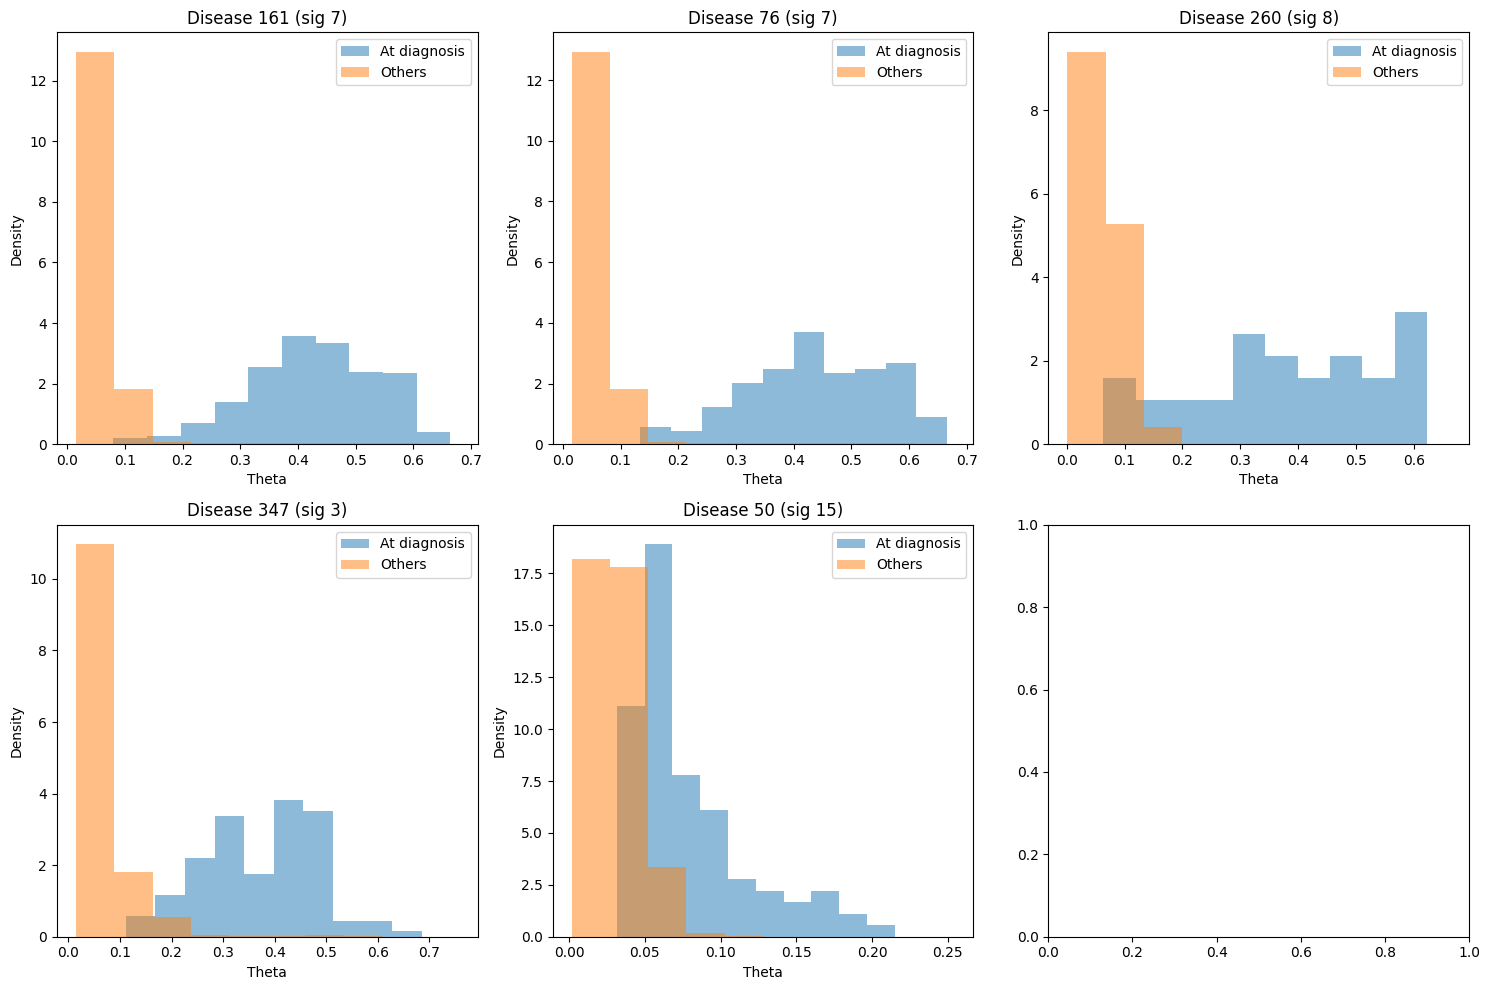

In [301]:
plot_theta_differences()

In [464]:
# Get μ_dt from checkpoint and predictions
mu_dt = model.prevalence_t  # Shape: (348, 52)



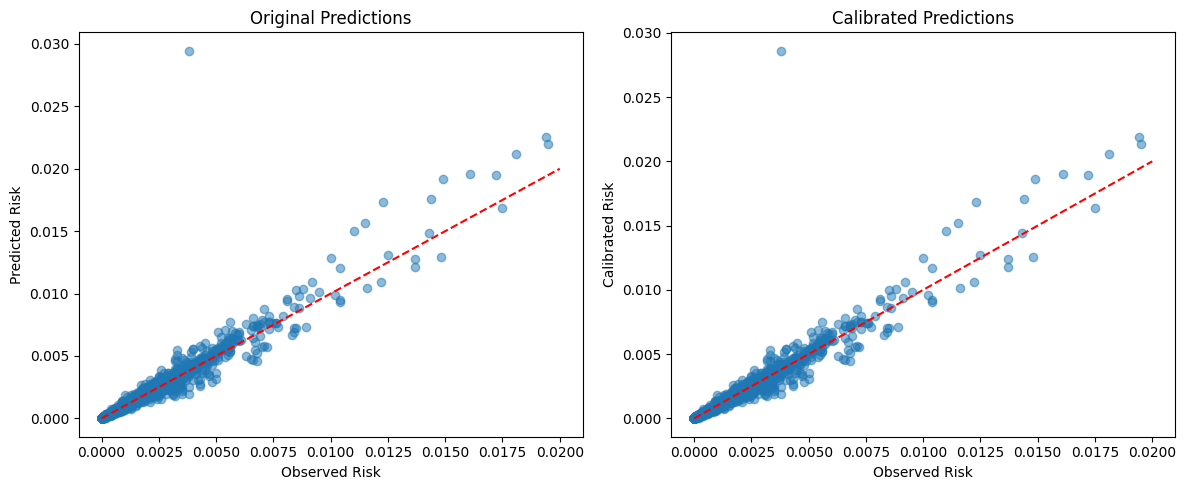

Mean observed risk: 0.000438
Mean predicted risk (original): 0.000451
Mean predicted risk (calibrated): 0.000438
Calibration scale factor: 0.971


In [465]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


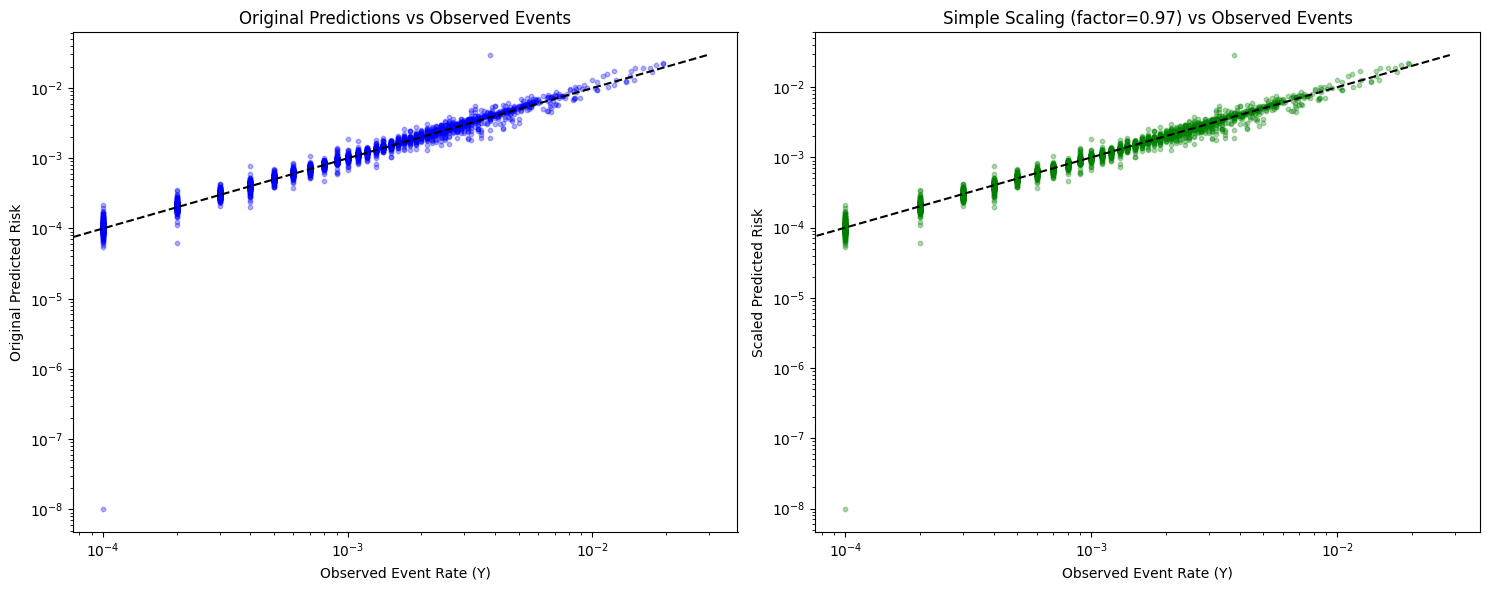

Scale factor: 0.971


In [466]:
# Get predictions
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
predicted_risk_2d = pi_pred.cpu().detach().numpy().mean(axis=0)  # average across individuals

# Get raw observations and calculate scale factor
Y_np = model.Y.cpu().detach().numpy()
Y_mean_2d = Y_np.mean(axis=0)  # average across individuals
scale_factor = Y_mean_2d.mean() / predicted_risk_2d.mean()
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs raw observations
ax1.scatter(Y_mean_2d.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Observed Event Rate (Y)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Observed Events')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs raw observations
ax2.scatter(Y_mean_2d.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         [0, max(Y_mean_2d.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Observed Event Rate (Y)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Observed Events')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Scale factor: {scale_factor:.3f}")

In [439]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.914


In [440]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Atrial fibrillation and flutter: effect=1.526 (OR=4.60), std=4.952
Paroxysmal supraventricular tachycardia: effect=0.223 (OR=1.25), std=4.759
Cardiomegaly: effect=0.208 (OR=1.23), std=4.912
Pleurisy; pleural effusion: effect=0.041 (OR=1.04), std=4.994
Heart failure NOS: effect=-0.391 (OR=0.68), std=4.387
Mitral valve disease: effect=-0.519 (OR=0.59), std=4.607
Pericarditis: effect=-0.630 (OR=0.53), std=4.293
Left bundle branch block: effect=-0.771 (OR=0.46), std=4.068
Congenital anomalies of great vessels: effect=-0.807 (OR=0.45), std=4.214
Primary/intrinsic cardiomyopathies: effect=-1.110 (OR=0.33), std=4.269

Top 10 diseases in Signature 1 (relative to baseline):
Arthropathy NOS: effect=3.681 (OR=39.70), std=3.379
Pain in joint: effect=3.436 (OR=31.07), std=2.921
Internal derangement of knee: effect=3.274 (OR=26.41), std=3.051
Other peripheral nerve disorders: effect=3.005 (OR=20.19), std=2.601
Hallux valgus (Bunion): effect=2.9

In [441]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Aortic valve disease: 1.180
2. Heart failure NOS: 1.147
3. Paroxysmal ventricular tachycardia: 1.106
4. Left bundle branch block: 1.072
5. Congestive heart failure (CHF) NOS: 1.044
6. Congenital anomalies of great vessels: 1.033
7. Atrial fibrillation and flutter: 1.027
8. Pericarditis: 1.004
9. Cardiomegaly: 0.999
10. Mitral valve disease: 0.982

Final top diseases:
1. Atrial fibrillation and flutter: 1.526
2. Paroxysmal supraventricular tachycardia: 0.223
3. Cardiomegaly: 0.208
4. Pleurisy; pleural effusion: 0.041
5. Heart failure NOS: -0.391
6. Mitral valve disease: -0.519
7. Pericarditis: -0.630
8. Left bundle branch block: -0.771
9. Congenital anomalies of great vessels: -0.807
10. Primary/intrinsic cardiomyopathies: -1.110

Congestive heart failure (CHF) NOS changed from rank 5 to 12

Heart failure NOS changed from rank 2 to 5

Congenital anomalies of great vessels changed from rank 6 to 9

Pleurisy; pleural effusion changed from rank 12 to

In [442]:
model.K=21

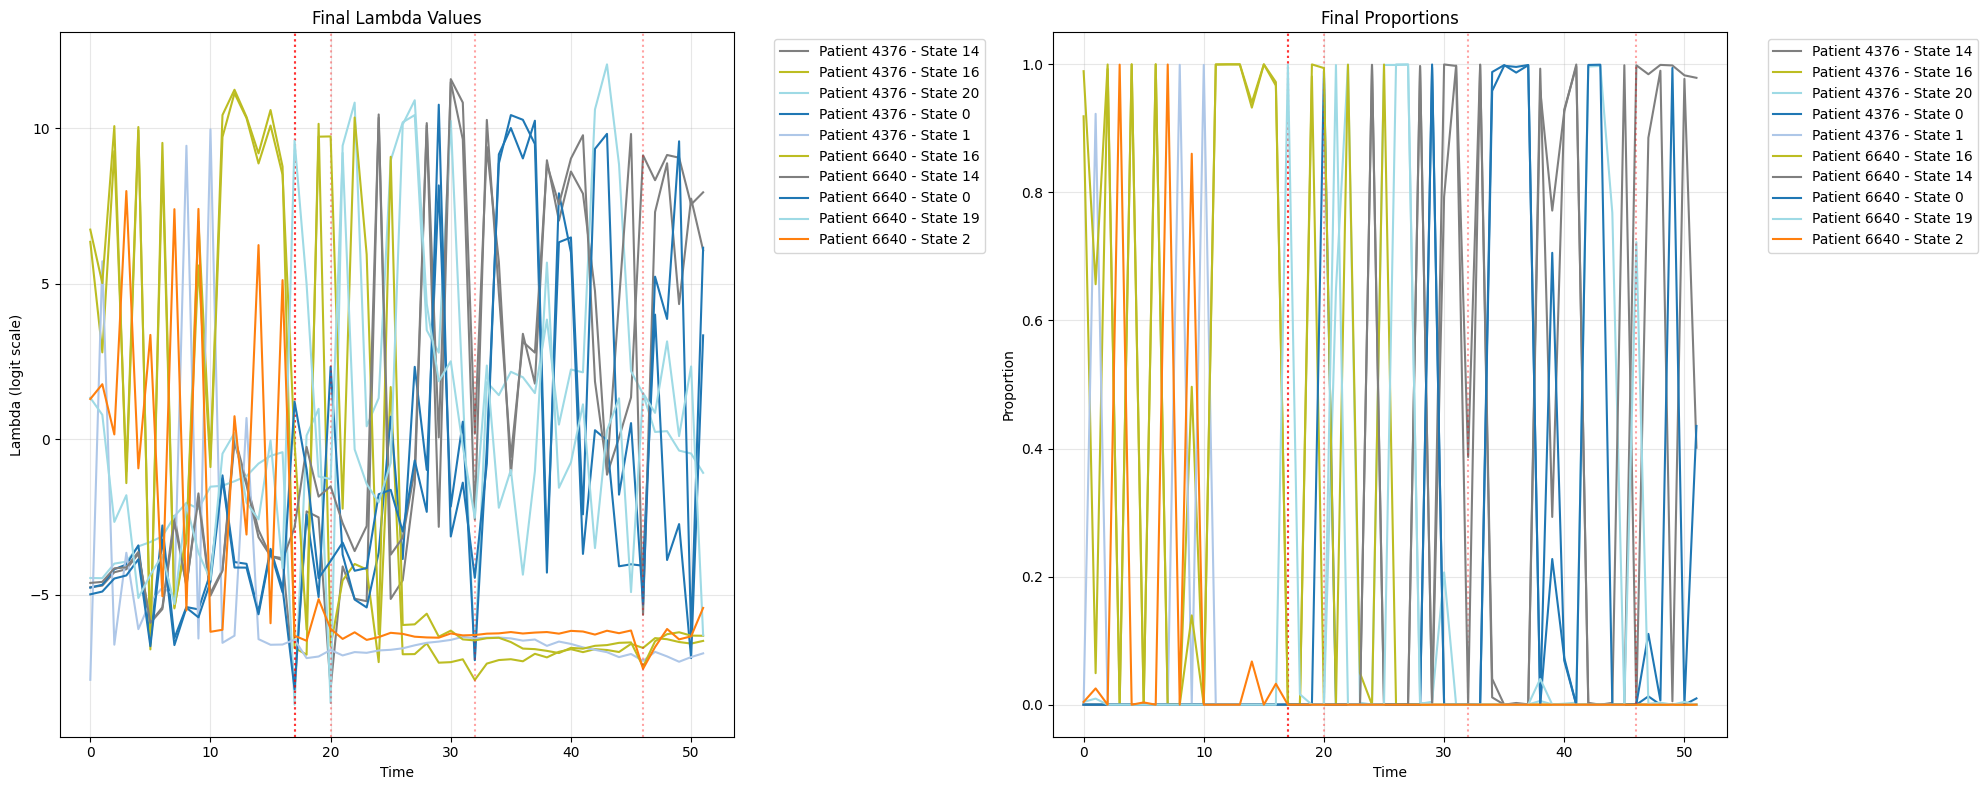


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 14: 0.276
State 16: 0.218
State 20: 0.147
State 0: 0.130
State 1: 0.056

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 16: 0.283
State 14: 0.249
State 0: 0.170
State 19: 0.092
State 2: 0.058


In [443]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    # Get diagnosis times for this patient
    diagnoses = model.Y[patient]  # Shape: [D, T]
    diagnosis_times = []
    for d in range(model.D):
        diag_time = torch.where(diagnoses[d])[0]
        if len(diag_time) > 0:
            diagnosis_times.append(diag_time[0].item())
            
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')
    
    # Add vertical lines for diagnoses
    for t in diagnosis_times:
        ax1.axvline(x=t, color='red', alpha=0.2, linestyle=':')
        ax2.axvline(x=t, color='red', alpha=0.2, linestyle=':')

# Customize plots
ax1.set_title('Final Lambda Values')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects and top states
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [388]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Dropbox (Personal)/first10kukb_pce.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [389]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=label)

In [390]:
def compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116]):
    """
    Compare 10-year predictions between our model and PCE at enrollment age
    """
    # Get predictions
    pi, theta, phi_prob = model.forward()
    
    # For each patient in pce_df
    our_10yr_risks = []
    actual_10yr = []
    
    for patient_idx, row in enumerate(pce_df.itertuples()):
        # Get enrollment time point (age - 30)
        enroll_time = int(row.age - 30)
        
        if enroll_time + 10 >= model.T:  # Skip if we don't have 10 years of follow-up
            continue
            
        # Get ASCVD predictions for this patient
        pi_ascvd = pi[patient_idx, ascvd_indices, enroll_time:enroll_time+10]  # [n_ascvd, 10]
        
        # Calculate 10-year risk from enrollment:
        # 1. For each time, prob of ANY ASCVD event
        ascvd_timeprob = 1 - torch.prod(1 - pi_ascvd, dim=0)  # [10]
        # 2. Prob of ANY event across time
        risk = 1 - torch.prod(1 - ascvd_timeprob)
        our_10yr_risks.append(risk.item())
        
        # Get actual outcomes
        Y_ascvd = model.Y[patient_idx, ascvd_indices, enroll_time:enroll_time+10]
        actual = torch.any(torch.any(Y_ascvd, dim=0))
        actual_10yr.append(actual.item())
    
    our_10yr_risks = np.array(our_10yr_risks)
    actual_10yr = np.array(actual_10yr)
    pce_risks = pce_df['pce_goff'].values[:len(our_10yr_risks)]
    
    # Calculate ROC AUCs
    our_auc = roc_auc_score(actual_10yr, our_10yr_risks)
    pce_auc = roc_auc_score(actual_10yr, pce_risks)
    
    print(f"\nROC AUC Comparison (10-year prediction from enrollment):")
    print(f"Our model: {our_auc:.3f}")
    print(f"PCE: {pce_auc:.3f}")
    
    # Plot ROC curves
    plt.figure(figsize=(8,6))
    plot_roc_curve(actual_10yr, our_10yr_risks, label=f'Our Model (AUC={our_auc:.3f})')
    plot_roc_curve(actual_10yr, pce_risks, label=f'PCE (AUC={pce_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for 10-year ASCVD Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
compare_with_pce(model, pce_df)

/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN.

In [320]:
compare_with_pce(
    model=model,
    pce_df=pce_df,  # Pass the pandas DataFrame
    patient_ids=patient_ids,
    common_ids=pce_df.index.values,
    ascvd_indices=[111,112,113,114,115,116]
)

NameError: name 'patient_ids' is not defined

In [324]:
pce_df

,id,age,race,Sex,SmokingStatusv2,tchol,hdl,SBP,antihtnbase,dm2_prev,dm1_prev,pce_goff
1,1000015,69,white,Male,Previous,160.440834,38.592420,146,0,0,0,0.208619
2,1000023,44,white,Male,Current,238.631089,35.460170,145,0,0,0,0.128707
3,1000037,69,white,Female,Previous,265.003865,54.988399,152,0,0,0,0.128959
4,1000042,66,white,Male,Never,187.277648,47.911833,130,0,0,0,0.137629
5,1000059,54,white,Female,Previous,203.750965,48.221191,152,0,0,0,0.029323
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1123554,62,white,Male,Never,215.854600,70.108275,118,0,0,0,0.075144
9997,1123563,66,white,Male,Previous,213.534415,31.786543,170,0,0,0,0.281062
9998,1123575,58,white,Male,Previous,199.845320,36.890951,159,0,0,0,0.132017
9999,1123587,58,white,Male,Previous,205.955142,55.143078,169,0,0,0,0.110945


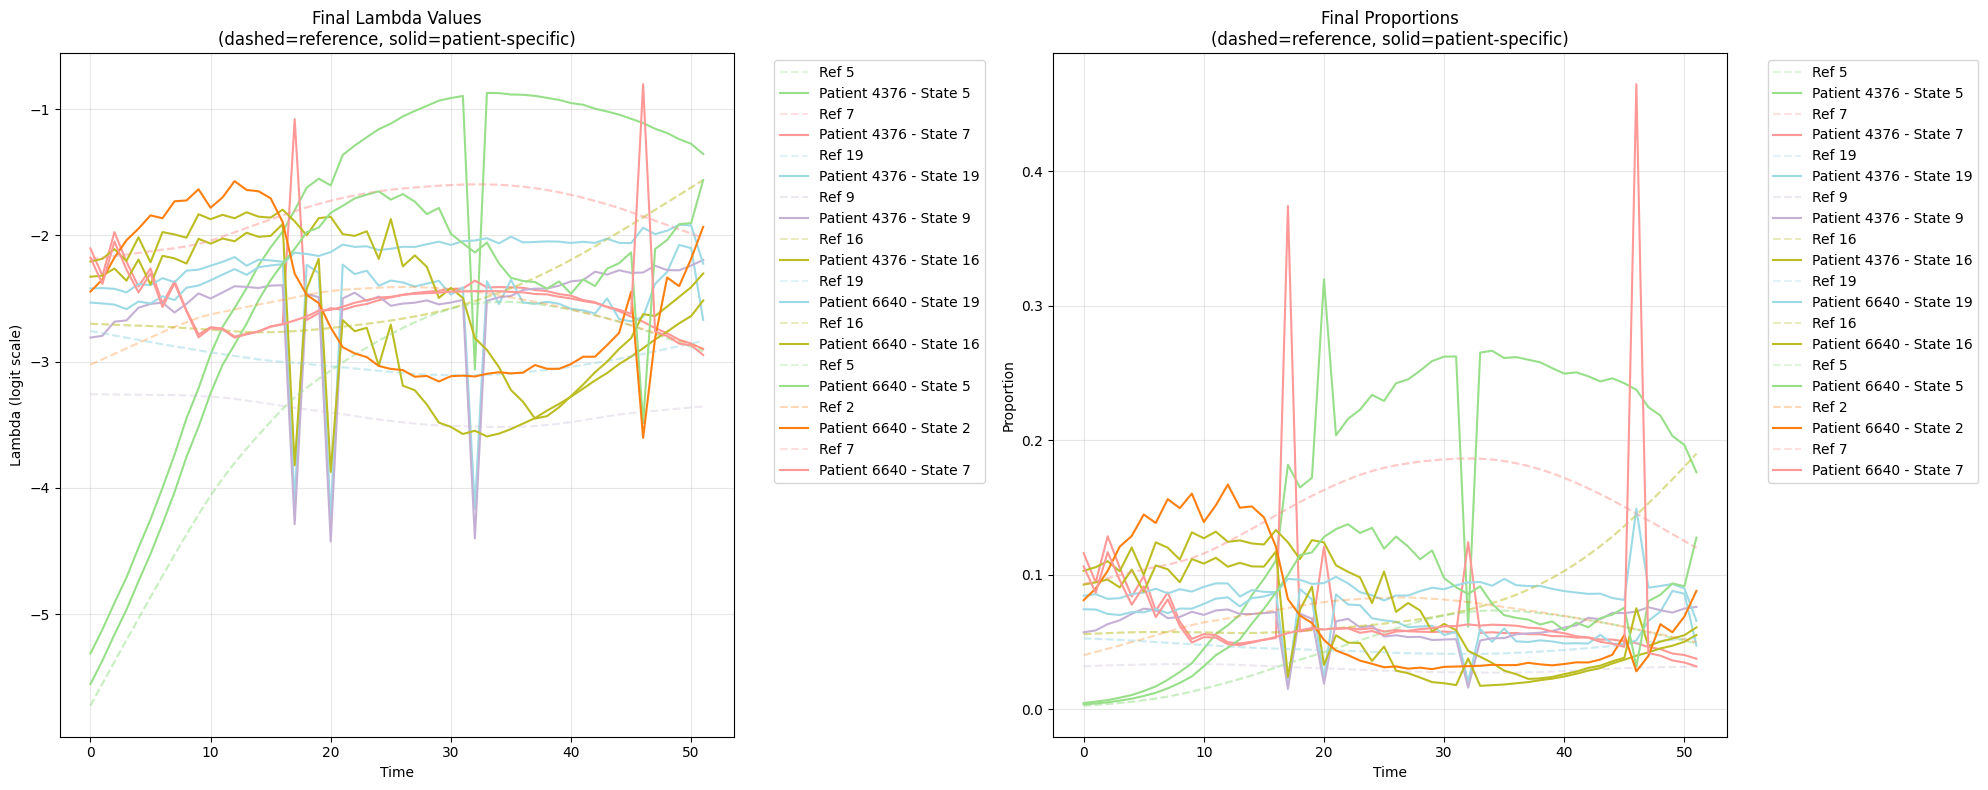


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.139
Range of shifts: [-0.131, 0.461]

Top states and average proportions:
State 5: 0.169
State 7: 0.070
State 19: 0.068
State 9: 0.062
State 16: 0.057

Patient 6640:
Mean shift: 0.040
Std of shifts: 0.079
Range of shifts: [-0.164, 0.232]

Top states and average proportions:
State 19: 0.086
State 16: 0.080
State 5: 0.073
State 2: 0.073
State 7: 0.068


In [ ]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate both calibration methods
# Simple scaling
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
scaled_risk = predicted_risk * scale_factor

# LOESS calibration
loess_risk = lowess(observed_risk, predicted_risk, frac=0.3, return_sorted=False)

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original predictions
ax1.scatter(observed_risk, predicted_risk, alpha=0.5, s=20)
ax1.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax1.set_title('Original Predictions')
ax1.set_xlabel('Observed Risk')
ax1.set_ylabel('Predicted Risk')
ax1.legend()

# Simple scaling calibration
ax2.scatter(observed_risk, scaled_risk, alpha=0.5, s=20)
ax2.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f})')
ax2.set_xlabel('Observed Risk')
ax2.set_ylabel('Scaled Risk')
ax2.legend()

# LOESS calibration
ax3.scatter(observed_risk, loess_risk, alpha=0.5, s=20)
ax3.plot([0, max(observed_risk)], [0, max(observed_risk)], 'k--', label='x=y line')
ax3.set_title('LOESS Calibration')
ax3.set_xlabel('Observed Risk')
ax3.set_ylabel('LOESS Calibrated Risk')
ax3.legend()

# Calibration curves comparison
sort_idx = np.argsort(predicted_risk)
pred_sorted = predicted_risk[sort_idx]
obs_sorted = observed_risk[sort_idx]
smoothed = lowess(obs_sorted, pred_sorted, frac=0.3)

ax4.scatter(predicted_risk, observed_risk, alpha=0.3, s=20, label='Data points')
ax4.plot(pred_sorted, pred_sorted * scale_factor, 'g-', label='Simple scaling', linewidth=2)
ax4.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOESS curve', linewidth=2)
ax4.plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'k--', label='x=y line')
ax4.set_title('Calibration Curves Comparison')
ax4.set_xlabel('Predicted Risk')
ax4.set_ylabel('Observed Risk')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
from sklearn.metrics import r2_score, mean_squared_error
print("\nPerformance Metrics:")
print(f"Original R²: {r2_score(observed_risk, predicted_risk):.3f}")
print(f"Simple Scaling R²: {r2_score(observed_risk, scaled_risk):.3f}")
print(f"LOESS Calibrated R²: {r2_score(observed_risk, loess_risk):.3f}")
print(f"\nOriginal RMSE: {np.sqrt(mean_squared_error(observed_risk, predicted_risk)):.6f}")
print(f"Simple Scaling RMSE: {np.sqrt(mean_squared_error(observed_risk, scaled_risk)):.6f}")
print(f"LOESS Calibrated RMSE: {np.sqrt(mean_squared_error(observed_risk, loess_risk)):.6f}")

In [ ]:
essentials['prevalence_t']

In [ ]:
# Get μ_dt from checkpoint and predictions

mu_dt = essentials['prevalence_t'] # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()